/home/ardie85/PHD/Research/code/.venv/lib/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


input dim type: <class 'int'>
action dim type: <class 'int'>
input dim type: <class 'int'>
action dim type: <class 'int'>
input dim type: <class 'int'>
action dim type: <class 'int'>
input dim type: <class 'int'>
action dim type: <class 'int'>
Step 1 of Episode 0
action generated from NN: [ 0.1442 -0.025 ]
action type of agent 0: problem solver
action generated from NN: [ 0.0473 -0.1016]
action type of agent 1: problem solver
observation before pass: tensor([-0.9000,  0.9000,  0.0000,  0.0000,  0.0000, -0.8000,  0.0000],
       device='cuda:0')
physical action before pass: tensor([ 0.1442, -0.0250], device='cuda:0', dtype=torch.float64)
reward before pass: tensor([0.0007], device='cuda:0')
next observation before pass: tensor([-8.9892e-01,  8.9981e-01,  1.4420e-02, -2.5000e-03,  0.0000e+00,
        -8.0000e-01,  9.9000e+01,  9.9000e+01,  4.7300e-02, -1.0160e-01,
         0.0000e+00,  0.0000e+00], device='cuda:0', dtype=torch.float64)
dones before pass: tensor([[False, False]], device='

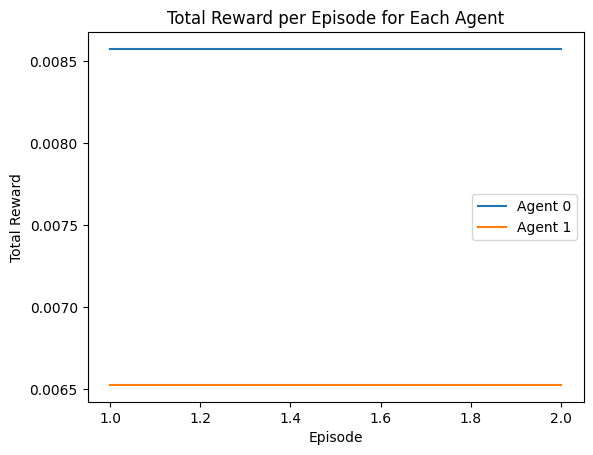

MoviePy - Building file navigation_comm.gif with imageio.


In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import json
import ast
from vmas import make_env
from vmas.simulator.core import Agent
from vmas.simulator.scenario import BaseScenario
from typing import Union
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML, display as ipython_display
import numpy as np
import matplotlib.pyplot as plt
from gym.spaces import Discrete
import math
from collections import deque 


class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim):
        # print (f"input dim type: {type(input_dim)}")
        # print (f"action dim type: {type(action_dim)}")

        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        value = self.critic(x)
        policy_dist = torch.tanh(self.actor(x))
        policy_dist = torch.round(policy_dist * 10000) / 10000
        return policy_dist, value

    

class ProblemSolver:
    def __init__(self, env, agent_id, state_dim, action_dim, device, alpha=0.1, gamma=0.99, epsilon=0.2, K_epochs=4, batch_size=64, communication_weight=0.5):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.K_epoch = K_epochs
        self.batch_size = batch_size
        self.q_table = {}
        self.env = env
        self.agent_id = agent_id
        self.communication_weight = communication_weight  # Weight parameter for incorporating messages
        self.device = device

        self.policy = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=alpha)
        self.policy_old = ActorCritic(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory = deque(maxlen=10000)

    
    def get_action_discrete(self, agent, env, agent_id, agent_obs):
        agent_obs_cpu = agent_obs[:6].cpu().numpy()  # Transfer only the required slice to CPU
        agent_obs = tuple(np.round(agent_obs_cpu, decimals=5))  # Round the observation

        if agent_obs not in self.q_table:
            self.q_table[agent_obs] = np.zeros(self.env.action_space[self.agent_id].n)

        if np.random.rand() < self.epsilon:
            # Select a random action
            action = np.random.randint(env.action_space[self.agent_id].n)
        else:
            # Select the action with the highest Q-value
            action = np.argmax(self.q_table[agent_obs])
        
        return (action,)  # Return as a tuple
    
    def update_action_discrete(self,  agent, env, agent_id, obs, action, reward, next_obs):
        obs_key = tuple(np.round(obs.cpu().numpy(), decimals=5))  # Only transfer to CPU when necessary
        next_obs_key = tuple(np.round(next_obs.cpu().numpy(), decimals=5))
        action = int(action.item())  # Convert tensor to Python scalar

        # print (f"reward obtained = {reward}")

        if isinstance(self.env.action_space[self.agent_id], Discrete):
            action_space_size = self.env.action_space[self.agent_id].n
        else:
            raise ValueError("This Q-learning implementation requires a discrete action space.")

        if obs_key not in self.q_table:
            self.q_table[obs_key] = np.zeros(action_space_size)

        if next_obs_key not in self.q_table:
            self.q_table[next_obs_key] = np.zeros(action_space_size)

        best_next_action = np.argmax(self.q_table[next_obs_key])
        td_target = reward + self.gamma * self.q_table[next_obs_key][best_next_action]

        td_error = td_target - self.q_table[obs_key][action]
        self.q_table[obs_key][action] += self.alpha * td_error

        print(f"Agent {self.agent_id} - Updated Q-table for obs {obs_key}, action {action}, reward {reward}, next_obs {next_obs_key}")

    
    def print_q_table(self):
        print(f"Q-table for Agent {self.agent_id}:")
        for state, actions in self.q_table.items():
            print(f"  State: {state}")
            for action, q_value in enumerate(actions):
                print(f"    Action: {action}, Q-value: {q_value:.5f}")
        print(f"End of Q-table for Agent {self.agent_id}\n")


    def get_action_continuous(self, agent, env, agent_id, agent_obs, device):
        state = torch.Tensor(agent_obs[:6]).to(device) if not isinstance(agent_obs[:6], torch.Tensor) else agent_obs[:6].to(device)
        state = state.float()  # Ensure the state is float32
        with torch.no_grad():
            policy_dist, _ = self.policy_old(state)
        action = policy_dist.cpu().numpy()

        print(f"action generated from NN: {action}")
        
        return action


    def update_action_continuous(self, agent_obs, action, reward, next_obs, done):
        agent_obs = torch.tensor(agent_obs[:6], dtype=torch.float32).to(self.device)
        next_obs = torch.tensor(next_obs[:6], dtype=torch.float32).to(self.device)
        action = torch.tensor(action, dtype=torch.float32).to(self.device)
        # done = torch.tensor(done, dtype=torch.float32).to(self.device)

        # print (f"observation received for update: {agent_obs}")
        # print (f"action received for update: {agent_obs}")
        # print (f"reward received for update: {reward}")
        # print (f"next observation received for update: {next_obs}")
        # print (f"done received for update: {done}")

        # Calculate advantage
        _, value = self.policy(agent_obs)
        _, next_value = self.policy(next_obs)
        # target_value = reward + self.gamma * next_value * (1 - done)
        target_value = reward + self.gamma * next_value * (~done)
        advantage = (target_value - value).detach()

        # Calculate the log probability of the action under the current policy
        mu, sigma = self.policy(agent_obs)
        sigma = torch.exp(sigma) 
        # print(f"mu: {mu}")
        # print(f"sigma: {sigma}")
        dist = torch.distributions.Normal(mu, sigma)
        
        log_prob = dist.log_prob(action).sum()

        # Calculate the log probability of the action under the old policy
        with torch.no_grad():
            mu_old, sigma_old = self.policy_old(agent_obs)
            sigma_old = torch.exp(sigma_old) 
            dist_old = torch.distributions.Normal(mu_old, sigma_old)
            old_log_prob = dist_old.log_prob(action).sum()

        # Policy ratio
        ratio = torch.exp(log_prob - old_log_prob)

        # PPO objective with clipping
        surrogate1 = ratio * advantage
        surrogate2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * advantage
        policy_loss = -torch.min(surrogate1, surrogate2).mean()

        # Value function loss
        value_loss = nn.MSELoss()(value, target_value.detach())

        # Total loss
        loss = policy_loss + 0.5 * value_loss

        # Update the actor-critic model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        print(f"Agent {self.agent_id} - PPO update: policy loss = {policy_loss.item()}, value loss = {value_loss.item()}")

    def print_model_parameters(self):
        print(f"Model parameters for Agent {self.agent_id}:")
        for name, param in self.actor_critic.named_parameters():
            print(f"  {name}: {param.data.numpy()}")
        print(f"End of model parameters for Agent {self.agent_id}\n")


class Case:
    added_states = set()  # Class attribute to store states already added to the case base

    def __init__(self, problem, solution, reward,  trust_value=1):
        # self.problem = problem if isinstance(problem, list) else ast.literal_eval(problem)  # Convert problem to numpy array
        self.problem = problem
        self.solution = solution
        self.reward = reward
        self.trust_value = trust_value
    
    @staticmethod
    def sim_q(state1, state2):
        state1 = np.atleast_1d(state1)
        state2 = np.atleast_1d(state2)
        CNDMaxDist = 6  # Maximum distance between two nodes in the-0.9, 0.7, 0.0, 0.0, 0.0, -0.9) CND based on EOPRA reference
        v = state1.size  # Total number of objects the agent can perceive
        DistQ = np.sum([Case.dist_q(Objic, Objip) for Objic, Objip in zip(state1, state2)])
        similarity = (CNDMaxDist * v - DistQ) / (CNDMaxDist * v)
        return similarity

    @staticmethod
    def dist_q(X1, X2):
        return np.min(np.abs(X1 - X2))

    @staticmethod
    def retrieve(agent, env, state, case_base, threshold=0.1):

        # Convert the state to numpy if it's a tensor
        if isinstance(state, torch.Tensor):
            state = state.cpu().numpy()

        # Slice the physical observations
        physical_obs = state[:6]

        if not agent.silent:
            comm_obs = state[6:]
            # Convert comm_obs to a numpy array if it is a tensor
            if isinstance(comm_obs, torch.Tensor):
                comm_obs = comm_obs.cpu().numpy()

        # print(f"physical_obs = {physical_obs}")

        # Ensure the state is in a list format to avoid issues with ast.literal_eval
        state_list = state.tolist() if isinstance(state, np.ndarray) else state
        state_str = json.dumps(state_list)  # Convert list to a JSON string for ast.literal_eval

        # Use ast.literal_eval safely to convert the string back to a list
        state = ast.literal_eval(state_str)

        similarities = {}
        for case in case_base:
            problem_numeric = np.array(case.problem, dtype=float)
            state_numeric = np.array(state, dtype=float)
            
            # print(f"state received = {state_numeric}")
            # print(f"case received = {problem_numeric}")
            # print("---------")
           
            similarities[case] = Case.sim_q(state_numeric, problem_numeric)  # Compare state with the problem part of the case

        sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

        if sorted_similarities:
            most_similar_case = sorted_similarities[0][0] if sorted_similarities[0][1] >= threshold else None
        else:
            most_similar_case = None

        return most_similar_case


    @staticmethod
    def reuse(c, temporary_case_base):
        temporary_case_base.append(c)

    @staticmethod
    def revise(case_base, temporary_case_base, successfull_task):
        for case in temporary_case_base:
            if successfull_task and case in case_base:
                case.trust_value += 0.1  # Increment trust value if the episode ended successfully and the case is in the case base
            elif not successfull_task and case in case_base:
                case.trust_value -= 0.1  # Decrement trust value if the episode ended unsuccessfully and the case is in the case base
            case.trust_value = max(0, min(case.trust_value, 1))  # Ensure trust value is within [0, 1]

    @staticmethod
    def retain(case_base, temporary_case_base, successfull_task, threshold=0.7):
        if successfull_task:
            # Iterate through the temporary case base to find the last occurrence of each unique state
            for case in reversed(temporary_case_base):
                state = tuple(np.atleast_1d(case.problem))
                # Check if the state is already in the case base or has been added previously
                if state not in Case.added_states:
                    # Add the case to the case base if the state is new
                    case_base.append(case)
                    Case.added_states.add(state)
                else:
                    # Find the index of the existing case in the case base
                    existing_index = next((i for i, c in enumerate(case_base) if tuple(np.atleast_1d(c.problem)) == state), None)
                    if existing_index is not None:
                        # Get the existing case from the case base
                        existing_case = case_base[existing_index]
                        # Update the trust value of the existing case with the new value from the revise step
                        existing_case.trust_value = case.trust_value

        # Filter case_base based on trust_value
        case_base = [case for case in case_base if case.trust_value >= threshold]
        return case_base


class QCBRLVmasRunner:
    def __init__(
        self,
        render: bool,
        num_envs: int,
        num_episodes: int,
        max_steps_per_episode: int,
        device: str,
        scenario: Union[str, BaseScenario],
        continuous_actions: bool,
        random_action: bool,
        n_agents: int,
        obs_discrete: bool = False,
        **kwargs
    ):
        self.render = render
        self.num_envs = num_envs
        self.num_episodes = num_episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.device = device
        self.scenario = scenario
        self.continuous_actions = continuous_actions
        self.random_action = random_action
        self.obs_discrete = obs_discrete
        self.kwargs = kwargs
        self.frame_list = []  
        self.problem_solver_agents = []
        self.rewards_history = []  
        self.action_counts = {i: {} for i in range(n_agents)}  
        self.agent_rewards_history = {i: [] for i in range(n_agents)}
        self.successful_episodes_individual = {i: 0 for i in range(n_agents)}  # Track successful episodes for each agent
        self.successful_episodes_all_agents = 0  # Track episodes where all agents succeed
        self.case_base = {i: [] for i in range(n_agents)}  # Separate case base for each agent
        self.temporary_case_base = {i: [] for i in range(n_agents)}  # Separate temporary case base for each agent

    

    def get_distance_category(self, distance):
        
        if distance == 0:
            distance_qualitative = 0 #at
        elif distance < 0.1:
            distance_qualitative = 1 #very close
        elif distance < 0.25:
            distance_qualitative = 2 #close
        elif distance < 0.5:
            distance_qualitative = 3 #far
        elif distance < 75:
            distance_qualitative = 4 #far #very far
        else:
            distance_qualitative = 5 #farthest
        
        return distance_qualitative
        
    def get_direction_category(self, agent_x, agent_y, target_x, target_y):
        dx = target_x - agent_x
        dy = target_y - agent_y

        if dy > 0:
            if dx > 0:
                direction_qualitative = 1 #top right
            elif dx < 0:
                direction_qualitative = 2 #top left
            else:
                direction_qualitative = 3 #top
        elif dy < 0:
            if dx > 0:
                direction_qualitative = 4 #bottom right
            elif dx < 0:
                direction_qualitative = 5 #bottom left
            else:
                direction_qualitative = 6 #bottom
        else:
            if dx > 0:
                direction_qualitative = 7 #right
            elif dx < 0:
                direction_qualitative = 8 #left
            else:
                direction_qualitative = 0 #at
            
        return direction_qualitative

    def _get_qualitative_position(self, env, observation):

        pos_x = observation[0:1]
        pos_y = observation[1:2]
        vel = observation[2:4]
        goal_x = observation[4:5]
        goal_y = observation[5:6]    
        comms_data = observation[6:13]
        sensor_data = observation[13:]

        distance = math.sqrt((goal_x - pos_x)**2 + (goal_y - pos_y)**2) #Eucledian distance
        # print(f"distance: {distance}")
        distance_category = self.get_distance_category(distance)
        direction_category = self.get_direction_category(pos_x, pos_y, goal_x, goal_y)
      
        return distance_category, direction_category


    def _get_action(self, agent, env, agent_id, obs_qualitative, obs_quantitative, device):

        # print(f"obs_qualitative: {obs_qualitative}")
        # print(f"obs_quantitative: {obs_quantitative}")

        physical_action=[]
        comm_action_length = 4

        case = Case.retrieve(agent, env, obs_qualitative, self.case_base[agent_id], threshold=0.1)
                    
        if case:
           
            physical_action = case.solution
            print(f"action type of agent {agent_id}: case base")
        
        else:    
            
            physical_obs_quantitative = obs_quantitative[0:6]

            if self.continuous_actions:
                physical_action = self.problem_solver_agents[agent_id].get_action_continuous(agent, env, agent_id, physical_obs_quantitative, device)
                physical_action_tensor = torch.tensor(physical_action, device=self.device)
                # physical_action = (0.1, -0.5)
               
            else:
                physical_action = self.problem_solver_agents[agent_id].get_action_discrete(agent, env, agent_id, physical_obs_quantitative, device)
            
           
        physical_action_tensor = torch.tensor(physical_action, device=self.device)
        zero_tensor = torch.zeros(comm_action_length, dtype=torch.float64, device=self.device)
        physical_action_tensor_padded = torch.cat((physical_action_tensor, zero_tensor))

        # print(f"physical action: {physical_action}")
        # print(f"physical action Tensor: {physical_action_tensor}")
        # print (f"shape of physical action: {physical_action_tensor.shape}")
            
        if agent.silent:
            action = physical_action_tensor_padded
        else:
            if not case:
                obs_qualitative_tensor = torch.tensor([float(99), float(99)], device=self.device)
                reward_tensor = torch.tensor([float(0)], device=self.device)
                trust_value_tensor = torch.tensor([float(0)], device=self.device)
            else:  
                obs_qualitative_tensor = torch.tensor(case.problem, device=self.device)
                reward_tensor = torch.tensor(case.reward, device=self.device)
                trust_value_tensor = torch.tensor(case.trust_value, device=self.device)

            comm_action_tensor = torch.cat([obs_qualitative_tensor, physical_action_tensor, reward_tensor, trust_value_tensor], dim=0)
            action = torch.stack((physical_action_tensor_padded, comm_action_tensor)).unsqueeze(0)

                # print(f"Comm action Tensor: {comm_action_tensor}")
                # print (f"shape of Comm action: {comm_action_tensor.shape}")
            
            print(f"action type of agent {agent_id}: problem solver")

        # else:
        #     obs_qualitative_tensor = torch.tensor(obs_qualitative, device=self.device)
        #     reward_tensor = torch.tensor([2.4], device=self.device)
        #     trust_value_tensor = torch.tensor([1], device=self.device)

        #     comm_action_tensor = torch.cat([obs_qualitative_tensor, physical_action_tensor, reward_tensor, trust_value_tensor], dim=0)
        #     action = torch.stack((physical_action_tensor_padded, comm_action_tensor)).unsqueeze(0)


        # print(f"action delivered from the function: {action}")
        # print (f"shape of action: {action.shape}")

        return action


    def save_case_base(self, agent_id):
        filename = f"cases/case_base_{agent_id}.json"
        case_base_data = []
        for case in self.case_base[agent_id]:
            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Case base saved successfully.")

    def save_case_base_eps(self, agent_id, eps):
        filename = f"cases/case_base_{agent_id}_{eps}.json"
        case_base_data = []
        for case in self.case_base[agent_id]:
            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Case base saved successfully.")


    def save_case_base_temporary(self, agent_id,):
        filename = f"cases/case_base_temporary_{agent_id}.json"
        case_base_data = []
        for case in self.temporary_case_base[agent_id]:
            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Temporary case base saved successfully.")

    def save_case_base_temporary_eps(self, agent_id, eps):
        filename = f"cases/case_base_temporary_{agent_id}_{eps}.json"
        case_base_data = []
        for case in self.temporary_case_base[agent_id]:
            problem = case.problem.tolist() if isinstance(case.problem, np.ndarray) else case.problem
            
            if torch.is_tensor(case.solution):
                solution = case.solution.tolist() if case.solution.numel() > 1 else int(case.solution.item())
            else:
                solution = int(case.solution)
            
            if torch.is_tensor(case.trust_value):
                trust_value = case.trust_value.tolist() if case.trust_value.numel() > 1 else float(case.trust_value.item())
            else:
                trust_value = float(case.trust_value)
            
            case_base_data.append({
                "problem": problem,
                "solution": solution,
                "trust_value": trust_value
            })
        
        with open(filename, 'w') as file:
            json.dump(case_base_data, file)

        print("Temporary case base saved successfully.")

        
    def load_case_base(self, agent_id):
        filename = f"cases/case_base_{agent_id}.json"
        try:
            with open(filename, 'r') as file:
                case_base_data = json.load(file)
            self.case_base[agent_id] = [Case(problem=np.array(case["problem"]) if isinstance(case["problem"], list) else case["problem"],
                                            solution=case["solution"],
                                            trust_value=case["trust_value"]) for case in case_base_data]
        except FileNotFoundError:
            self.case_base[agent_id] = []

    
    def generate_gif(self, scenario_name):
        fps = 25
        clip = ImageSequenceClip(self.frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)
        return HTML(f'<img src="{scenario_name}.gif">')

    def plot_action_distribution(self):
        num_agents = len(self.action_counts)

        for agent_id, counts in self.action_counts.items():
            unique_actions, action_counts = np.unique(list(counts.values()), return_counts=True)
            action_dict = dict(zip(unique_actions, action_counts))
            plt.bar(action_dict.keys(), action_dict.values(), label=f'Agent {agent_id}', alpha=0.7)

        plt.xlabel('Action')
        plt.ylabel('Frequency')
        plt.title('Action Distribution for Each Agent')
        plt.legend()
        plt.show()

    def plot_rewards_history(self):
        num_agents = len(self.agent_rewards_history)

        for agent_id, rewards in self.agent_rewards_history.items():
            plt.plot(range(1, self.num_episodes + 1), rewards, label=f'Agent {agent_id}')

        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Total Reward per Episode for Each Agent')
        plt.legend()
        plt.show()


    def run_vmas_env(self):
        scenario_name = self.scenario if isinstance(self.scenario, str) else self.scenario.__class__.__name__

        env = make_env(
            scenario=self.scenario,
            num_envs=self.num_envs,
            device=self.device,
            continuous_actions=self.continuous_actions,
            **self.kwargs
        )
        
        states = env.reset()
        # print(f"states first agent after reset: {states}")
        # print(f"states first agent shape after reset: {states[0].shape}")
        first_agent_state = states[0][0:6]
        state_dim = first_agent_state.shape[0]
        action_dim = len(env.action_space)
        # print(f"states after reset: {states}")
        # print(f"state dim: {state_dim}")
        # print(f"action dim: {action_dim}")
        
        for agent_id, agent in enumerate(env.agents):
            self.problem_solver_agents.append(ProblemSolver(env, agent_id, state_dim, action_dim, self.device, communication_weight=0.5))

        init_time = time.time()
        total_steps = 0
        is_episode_success = False

        for episode in range(self.num_episodes):
            # print(f"Episode {episode}")
            obs_cont = env.reset()
            # print(f"observation continous: {obs_cont}")

            dones = torch.tensor([False] * self.num_envs, device=self.device)
            step = 0
            
            episode_rewards = {i: 0 for i in range(len(self.problem_solver_agents))}
            episode_dones_counts = {i: 0 for i in range(len(env.agents))}  # Track dones counts for each agent
            
            self.temporary_case_base = {i: [] for i in range(len(env.agents))}
            
            while not torch.all(dones).item() and step < self.max_steps_per_episode:
                step += 1
                total_steps += 1
                print(f"Step {step} of Episode {episode}")

                actions = []
               

                for agent_id, agent in enumerate(env.agents):
                    # print(f"agent {agent_id}")
                    # print(f"agent {agent}")
                    if self.obs_discrete:
                        obs_qualitative = self._get_qualitative_position(env, obs_cont[agent_id])
                        
                    # print(f"observation continuous agent{agent_id} = {obs_cont[agent_id]}")
                    # print(f"observation qualitative agent{agent_id} = {obs_qualitative}")

                    action = self._get_action(agent, env, agent_id, obs_qualitative, obs_cont[agent_id], self.device)
                    
                    actions.append(action)


                # print(f"action taken: {actions}")
                # print(f"actions agent {agent_id} shapes: {actions[agent_id].shape}")
                # print(f"actions size from environment: {env.get_agent_action_size(agent)}")

                next_obs_cont, rewards, dones, info = env.step(actions)
                # print(f"next obs first agents = {next_obs_cont[0]}")
                # print(f"next obs first agents shape = {next_obs_cont[0].shape}")
                # print(f"reward all agents = {rewards}")
                

                for agent_id, agent in enumerate(env.agents):
                    if self.obs_discrete:
                        obs_qualitative = self._get_qualitative_position(env, obs_cont[agent_id])
                        discrete_next_obs = self._get_qualitative_position(env, next_obs_cont[agent_id])

                    problem = obs_qualitative
                    physical_action = actions[agent_id][0,0,0:2]
                    reward = rewards[agent_id]
                    done = dones[0][agent_id]

                    new_case = Case(problem, physical_action, reward)
                    Case.reuse(new_case, self.temporary_case_base[agent_id])

                    # print(f"observation before pass: {obs_cont[agent_id]}")
                    # print(f"physical action before pass: {physical_action}")
                    # print(f"reward before pass: {reward}")
                    # print(f"next observation before pass: {next_obs_cont[agent_id]}")
                    # print(f"dones before pass: {dones}")
                    # print(f"done before pass: {done}")

                    if self.continuous_actions:

                        self.problem_solver_agents[agent_id].update_action_continuous( 
                            obs_cont[agent_id], physical_action, reward, next_obs_cont[agent_id], done
                        )
                    else:
                        self.problem_solver_agents[agent_id].update_action_discrete(agent, env, agent_id,
                             obs_cont[agent_id], physical_action, rewards[agent_id].item(), next_obs_cont[agent_id]
                        )
                    # Accumulate rewards for each agent within the episode
                    episode_rewards[agent_id] += rewards[agent_id].item()
                    
                    print (f"dones: {dones[0]}")
                    if (dones[0][agent_id]):  # Increment individual agent's done count
                        episode_dones_counts[agent_id] += 1
                
                # done = dones
                obs_cont = next_obs_cont

                                
                # print(f"dones status for all agents = {done}")
                # print("--------------------")

                if self.render:
                    frame = env.render(
                        mode="rgb_array",
                        agent_index_focus=None,
                    )
                    self.frame_list.append(frame)

                # print("-----------------")
            # Update rewards history after each episode
            for agent_id, total_reward in episode_rewards.items():
                self.agent_rewards_history[agent_id].append(total_reward)

            # Update success based on individual agent's done status
            for agent_id in range(len(env.agents)):
                print(f"done status for agent {agent_id}: {dones[0][agent_id]}")
                # print(f"dones status for agent {agent_id} v2: {dones[0, agent_id]}")
                if dones[0][agent_id]:
                    self.successful_episodes_individual[agent_id] += episode_dones_counts[agent_id] / step  # Calculate success rate for the agent

            # Update success based on all agents' done status
            if torch.all(dones).item():
                self.successful_episodes_all_agents += 1
            
            # Calculate success percentages for each agent
            success_percents = [self.successful_episodes_individual[agent_id] / (episode + 1) * 100 for agent_id in range(len(env.agents))]
            overall_success_percent = self.successful_episodes_all_agents / (episode + 1) * 100

            print(f"Success percentage of each agent at the end of episode {episode}:")
            
            for agent_id, percent in enumerate(success_percents):
                print(f"Agent {agent_id}: {percent}%")

            print(f"Overall success percentage for all agents up to episode {episode}: {overall_success_percent}%")


            for agent_id in range(len(env.agents)):
                print(f"done status for agent {agent_id}: {dones[0][agent_id]}")
                
                # Case.revise(self.case_base[agent_id], self.temporary_case_base[agent_id], torch.any(dones).item())
                # self.case_base[agent_id] = Case.retain(
                #     self.case_base[agent_id], self.temporary_case_base[agent_id], torch.any(dones).item()
                # )

                Case.revise(self.case_base[agent_id], self.temporary_case_base[agent_id], dones[0][agent_id])
                self.case_base[agent_id] = Case.retain(
                    self.case_base[agent_id], self.temporary_case_base[agent_id], dones[0][agent_id]
                )

                # for case in self.temporary_case_base[agent_id]:
                #     print(f"Step {step} -- Problem Stored in Temp CB: {case.problem}, Solution Stored in Temp CB: {case.solution}")

                # for case in self.case_base[agent_id]:
                #     print(f"Step {step} -- Problem Stored in CB: {case.problem}, Solution Stored in CB: {case.solution}")

                self.save_case_base_temporary_eps(agent_id, episode)  # Save temporary case base after each episode
                self.save_case_base_eps(agent_id, episode)  # Save case base after each episode
            
            torch.cuda.empty_cache()  # Free up unused memory

        
        for agent_id, agent in enumerate(env.agents):
            self.save_case_base_temporary(agent_id)  # Save temporary case base after training
            self.save_case_base(agent_id)  # Save case base after training

        # Print final success percentages for each agent-0.9, 0.7, 0.0, 0.0, 0.0, -0.9)
        
        # Print overall success percentage for all agents
        overall_success_percentage = self.successful_episodes_all_agents / self.num_episodes * 100
        print(f"Overall success percentage for all agents = {overall_success_percentage}%")



        total_time = time.time() - init_time
        print(
            f"It took: {total_time}s for {total_steps} steps across {self.num_episodes} episodes of {self.num_envs} parallel environments on device {self.device} "
            f"for {scenario_name} scenario."
        )

        # success_percentage = (self.successful_episodes / self.num_episodes) * 100
        # print(f"Percentage of successful episodes: {success_percentage}%")


if __name__ == "__main__":
    scenario_name = "navigation_comm"
    use_cuda = True

    env_runner = QCBRLVmasRunner( 
        render=True,
        num_envs=1,
        num_episodes=2,
        max_steps_per_episode=5,
        device = torch.device("cuda" if use_cuda else "cpu"),
        scenario=scenario_name,
        continuous_actions=True,
        random_action=False,
        n_agents=2,
        obs_discrete=True,
        agents_with_same_goal=2,
        collisions=False,
        shared_rew=False,
    )

    env_runner.run_vmas_env()
    # for agent in env_runner.problem_solver_agents:
    #     agent.print_q_table()
    env_runner.plot_rewards_history()

    ipython_display(env_runner.generate_gif(scenario_name))
